In [3]:
!pip install sacrebleu

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.notebook import tqdm
from torchtext.vocab import build_vocab_from_iterator
import math, copy, time
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import wandb
import sacrebleu

plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Tokenization

In [5]:
def dataset_iterator(path):
    with open(path) as texts:
        for text in texts:
            yield text.split()

In [6]:
def build_vocab(path, min_freq):
    return build_vocab_from_iterator(
        dataset_iterator(path),
        specials=['<pad>', '<unk>', '<bos>', '<eos>'], min_freq=min_freq,
    )

In [7]:
def get_train_val_dataloaders(path: str, en_vocab, de_vocab, batch_size: int = 216) -> list[DataLoader]:
    '''
    Creating train and validation dataloaders from files with plain text.
    :param path: path to the folder with train and validation files
    :param batch_size: size of the batch in dataloader
    :return: train_loader, val_loader
    '''

    # tokenization of sequences
    # en_vocab['<bos>'] == 2
    # en_vocab['<eos>'] == 3
    train_en_tokens = []
    for text in dataset_iterator(f'{path}/data/train.de-en.en'):
        tokens = [2] + [en_vocab[word] if word in en_vocab else en_vocab['<unk>'] for word in text] + [3]
        train_en_tokens += [tokens]

    train_de_tokens = []
    for text in dataset_iterator(f'{path}/data/train.de-en.de'):
        tokens = [2] + [de_vocab[word] if word in de_vocab else de_vocab['<unk>'] for word in text] + [3]
        train_de_tokens += [tokens]

    test_en_tokens = []
    for text in dataset_iterator(f'{path}/data//val.de-en.en'):
        tokens = [2] + [en_vocab[word] if word in en_vocab else en_vocab['<unk>'] for word in text] + [3]
        test_en_tokens += [tokens]

    test_de_tokens = []
    for text in dataset_iterator(f'{path}/data//val.de-en.de'):
        tokens = [2] + [de_vocab[word] if word in de_vocab else de_vocab['<unk>'] for word in text] + [3]
        test_de_tokens += [tokens]


    # padding till max length of sequence
    max_length = 82

    tokenized_en_train = torch.full((len(train_en_tokens), max_length), en_vocab['<pad>'], dtype=torch.int32)
    for i, tokens in enumerate(train_en_tokens):
        length = min(max_length, len(tokens))
        tokenized_en_train[i, :length] = torch.tensor(tokens[:length])

    tokenized_de_train = torch.full((len(train_de_tokens), max_length), de_vocab['<pad>'], dtype=torch.int32)
    for i, tokens in enumerate(train_de_tokens):
        length = min(max_length, len(tokens))
        tokenized_de_train[i, :length] = torch.tensor(tokens[:length])

    tokenized_en_test = torch.full((len(test_en_tokens), max_length), en_vocab['<pad>'], dtype=torch.int32)
    for i, tokens in enumerate(test_en_tokens):
        length = min(max_length, len(tokens))
        tokenized_en_test[i, :length] = torch.tensor(tokens[:length])

    tokenized_de_test = torch.full((len(test_de_tokens), max_length), de_vocab['<pad>'], dtype=torch.int32)
    for i, tokens in enumerate(test_de_tokens):
        length = min(max_length, len(tokens))
        tokenized_de_test[i, :length] = torch.tensor(tokens[:length])

    # creating dataloaders
    train_dataset = TensorDataset(tokenized_de_train, tokenized_en_train) # for sync shuffle
    test_dataset = TensorDataset(tokenized_de_test, tokenized_en_test)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size, shuffle=False)

    return train_loader, val_loader
        

## Model

### Common utils

In [8]:
def clones(module: nn.Module, N: int) -> nn.ModuleList:
    '''
    Produce N identical layers.
    :param module: module that we want to copy
    :param N: number of copies that we want
    :return: N copies of module
    '''
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [9]:
class LayerNorm(nn.Module):
    "Construct a layernorm module."
    def __init__(self, size: int, eps: float =1e-6) -> None:
        '''
        :param size: size of embeddings that we will get
        :param eps: small constant
        '''
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(size))
        self.b_2 = nn.Parameter(torch.zeros(size))
        self.eps = eps

    def forward(self, x):
        '''
        :param x: input batch
        '''
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [10]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    """
    def __init__(self, size: int, dropout: float):
        '''
        :param size: size of layernorm
        :param dropout: dropout parameter
        '''
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        '''
        Apply residual connection to any sublayer with the same size.
        :param x: input of the layer
        :param sublayer: implementation of layer, which we wrap into residual connection
        :return: embedding of the same shape as x
        '''
        return x + self.dropout(sublayer(self.norm(x)))

In [11]:
def subsequent_mask(size: int):
    '''
    Mask out subsequent positions.
    :param size: size of attention layer
    :return: mask
    '''
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [12]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    def make_std_mask(self, tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

### Embeddings and Softmax

In [13]:
class Embeddings(nn.Module):
    "Wrapper for embedding module"
    def __init__(self, d_model: int, vocab_size: int):
        '''
        :param d_model: size of embeddings
        :param vocab_size: size of vocab
        '''
        super(Embeddings, self).__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        "translating into embedding and normalize"
        return self.emb(x) * math.sqrt(self.d_model)
    

### Feed-Forward

In [14]:
class PositionwiseFeedForward(nn.Module):
    "Implements Feed-Forward layer"
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        '''
        :param d_model: size of embeddings
        :param d_ff: size of latent represintation between 2 FC layers
        '''
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

### Positional Encoding

PE(pos, 2i) = sin(pos / (10000^(2i/d_model)))

PE(pos, 2i+1) = cos(pos / (10000^(2i/d_model)))

In [15]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

### Attention

Attention(Q,K,V)=softmax(QK^T/sqrt(d_k)) * V

In [16]:
def Attention(query, key, value, mask=None, dropout=None):
    '''
    Attention is all you need.
    :param query: embeds responsible for the query
    :param key: embeds responsible for the key
    :param value: embeds responsible for the value
    '''
    d_k = query.size(-1) # embed dim
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value)

In [17]:

class MultiHeadedAttention(nn.Module):
    def __init__(self, h: int, d_model: int, dropout: float = 0.1):
        '''
        Take in model size and number of heads.
        :param h: number of heads
        :param d_model: dimension of embeddings
        :param dropout: dropout probability
        '''
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        batch_size = query.size(0)
        
        # apply matrices WQ, WV, WK and split into self.h heads
        query, key, value = \
            [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # apply attention on all heads
        x = Attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # Concat using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(batch_size, -1, self.h * self.d_k)
        return self.linears[-1](x)

### encoder

In [18]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward"
    def __init__(self, size: int, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [19]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

### decoder

In [20]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
    

In [21]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

### EncoderDecoder

In [22]:
class Transformer(nn.Module):
    """
    A standard Encoder-Decoder architecture.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [23]:
class Generator(nn.Module):
    "Last FC layer."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.linear = nn.Linear(d_model, vocab)

    def forward(self, x):
        return self.linear(x)

### Full Model

In [24]:
def make_transformer(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # Initialize parameters with Xavier distribution
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## Training

### Optimizer

In [25]:
class WarmupOptimizer:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))


### Loss computation

In [26]:
class LossBLEUCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, en_vocab_reversed, calc_bleu, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.en_vocab_reversed = en_vocab_reversed
        self.calc_bleu = calc_bleu
        self.opt = opt
    
        
    def __call__(self, x, y):
        x = self.generator(x)
        bleu = 0
        if self.calc_bleu:
            next_tokens = torch.argmax(x, dim=2)
            # B * L * 1

            predicted_sentences = [' '.join([self.en_vocab_reversed[word] for word in next_sentence]) + '\n' for next_sentence in next_tokens]
            reference_sentences = [' '.join([self.en_vocab_reversed[word] for word in next_sentence]) + '\n' for next_sentence in y]
            
            bleu = sacrebleu.corpus_bleu(reference_sentences, [predicted_sentences]).score
        
        loss = self.criterion(x.transpose(1, 2), 
                              y.long())

        loss.backward()
        
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()

        return loss.item(), bleu

### Training Loop

In [27]:
def run_epoch(data_loader, model, loss_bleu_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 1
    total_loss = 0
    total_bleu = 0
    tokens = 0
    for i, src_trg in tqdm(enumerate(data_loader)):
        src, trg = src_trg
        batch = Batch(src, trg, 0)
        batch.src = batch.src.to(device)
        batch.trg = batch.trg.to(device)
        batch.src_mask = batch.src_mask.to(device)
        batch.trg_mask = batch.trg_mask.to(device)
        batch.trg_y = batch.trg_y.to(device)
        batch.ntokens = batch.ntokens.to(device)
        
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss, bleu = loss_bleu_compute(out, batch.trg_y)
        total_loss += loss
        total_bleu += bleu
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 200 == 1:
            elapsed = time.time() - start
#             print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
#                     (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens, total_bleu / total_tokens

In [28]:
def train_loop(num_epochs, model, train_loader, test_loader, train_loss_comp, test_loss_comp, config):
    wandb.login(key='46c3b8e339b3fb22dc286204510c8af5b2c3e2e5')
    wandb.init(
        project='DL_BHW_2',
        entity='bspanfilov',
        name=config['run_name'],
        config=config
    )
    train_loss, val_loss = [], []
    train_bleu, val_bleu = [], []
    for epoch in range(num_epochs):
        model.train()
        loss, bleu = run_epoch(train_loader, model, train_loss_comp)
        train_loss.append(loss)
        train_bleu.append(bleu)
        model.eval()
        loss, bleu = run_epoch(test_loader, model, test_loss_comp)
        val_loss.append(loss)
        val_bleu.append(bleu)
#         print('DELETE it after self-check')
#         print(f'Train loss after {epoch}th epoch: {train_loss[-1]}')
#         print(f'Val loss after {epoch}th epoch: {val_loss[-1]}')

        wandb.log({"train_loss": train_loss[-1], "val_loss": val_loss[-1]})
        wandb.log({"train_bleu": train_bleu[-1], "val_bleu": val_bleu[-1]})

    wandb.finish()

## Inference


In [29]:
def inference_loop(model, tokenized_src, en_vocab, max_length=90):
    en_reverse_vocab = en_vocab.get_itos()

    model.eval()
    trg_tokens = [en_vocab["<bos>"]]
    
    for _ in range(max_length):
        src = torch.tensor([tokenized_src]).to(device)
        trg = torch.tensor([trg_tokens]).to(device)
        with torch.no_grad():
            output = model.forward(src, trg, None, None)
        prob_distribution = model.generator(output[:, -1])
        print(f'prob_dist shape = {prob_distribution.shape}')
        next_token = torch.argmax(prob_distribution, dim=1).item()
        if next_token == en_vocab["<eos>"]:
            break
        trg_tokens.append(next_token)
    
    translated_sentence = [en_reverse_vocab[token] for token in trg_tokens][1:]
    
    return translated_sentence

## Experiments

In [30]:
import yaml
def read_config(config_path='config.yaml'):
    """Reads config from yaml file, see config.yaml

    Args:
        config_path (str, optional): path to config file. Defaults to CONFIG_PATH.

    Returns:
        dict: dictionary of configuration
    """
    with open(config_path, "r") as yaml_file:
        data = yaml.safe_load(yaml_file)
        return data


In [34]:
# config = read_config('config.yaml')
config = {'model': {'num_layers': 3,
  'embedding_dim': 128,
  'feedforward_dim': 512,
  'num_heads': 4,
  'dropout': 0.1},
 'batch_size': 64,
 'optimizer': {'factor': 1,
  'warmup': 400,
  'lr': 0.0001,
  'beta1': 0.9,
  'beta2': 0.98},
 'epochs': 10,
 'checkpoint': {'dir': 'checkpoints', 'step': 1},
 'outputfile': 'ans.txt',
 'path': '/kaggle/input/bhw2-data',
 'run_name': '3_128_512_4_with_bleu_checking',
 'min_freq': 10}

{'model': {'num_layers': 1,
  'embedding_dim': 2,
  'num_heads': 2,
  'feedforward_dim': 4,
  'dropout': 0.1},
 'batch_size': 32,
 'optimizer': {'factor': 1,
  'warmup': 400,
  'lr': 0.0001,
  'beta1': 0.9,
  'beta2': 0.98},
 'epochs': 10,
 'checkpoint': {'dir': 'checkpoints', 'step': 1},
 'outputfile': 'ans.txt',
 'path': 'bhw2-data',
 'run_name': 'first run',
 'min_freq': 10}

In [ ]:
config = read_config('config.yaml')

path = config['path']

en_vocab = build_vocab(f'{path}/data/train.de-en.en', config['min_freq'])
de_vocab = build_vocab(f'{path}/data/train.de-en.de', config['min_freq'])
len(en_vocab)
train_loader, val_loader = \
    get_train_val_dataloaders(path=path, en_vocab=en_vocab,
                                de_vocab=de_vocab, batch_size=config['batch_size'])

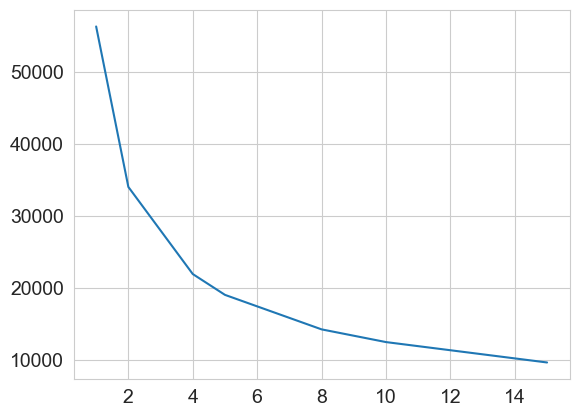

In [35]:
lens = []
min_freqs = [1, 2, 4, 5, 8, 10, 15]
for min_freq in min_freqs:
    config['min_freq'] = min_freq
    en_vocab = build_vocab(f'{path}/data/train.de-en.en', config['min_freq'])
    lens.append(len(en_vocab))

plt.plot(min_freqs, lens)

In [33]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
model = make_transformer(len(de_vocab), len(en_vocab),
                          N=config['model']['num_layers'],
                          d_model=config['model']['embedding_dim'],
                          d_ff=config['model']['feedforward_dim'], 
                          h=config['model']['num_heads']).to(device)
optimizer = WarmupOptimizer(model.src_embed[0].d_model, config['optimizer']['factor'], 
                            config['optimizer']['warmup'],
                            torch.optim.Adam(model.parameters(), lr=config['optimizer']['lr'], 
                                             betas=(config['optimizer']['beta1'], 
                                                    config['optimizer']['beta2']), 
                                             eps=1e-09))
num_epochs=config['epochs']


train_loop(num_epochs=num_epochs, model=model, train_loader=train_loader,
                            test_loader=val_loader,
                            train_loss_comp=LossBLEUCompute(model.generator, criterion, en_vocab.get_itos(), calc_bleu=False, opt=optimizer),
                            test_loss_comp=LossBLEUCompute(model.generator, criterion, en_vocab.get_itos(), calc_bleu=False, opt=None), config=config)


# not optimized, but working one loop for each sequence
with open(config['outputfile'], 'w') as ans_file:
    for text in dataset_iterator(f'{path}/data/test1.de-en.de'):
        tokens = [2] + [de_vocab[word] if word in de_vocab else de_vocab['<unk>'] for word in text] + [3]
        ans_file.write(' '.join(inference_loop(model=model, tokenized_src=tokens, en_vocab=en_vocab)) + '\n')
